# Cifar10 Pipeline

## Install packages

In [12]:
! pip uninstall -y kfp
! pip install kfp captum torchvision matplotlib pillow pytorch-lightning flask flask-compress ipywidgets minio

Found existing installation: kfp 1.6.3
Uninstalling kfp-1.6.3:
  Successfully uninstalled kfp-1.6.3
  Using cached kfp-1.6.3-py3-none-any.whl


In [71]:
# Node Version
! node --version

# Install yarn
! npm install -g npm
! npm install --global yarn
! yarn --version

v14.16.0
              ] / reify:npm: timing reify:createSparse Completed in 0msms
changed 14 packages, and audited 255 packages in 1s

11 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities
              ] \ reify:yarn: sill audit bulk request { yarn: [ '1.22.10'm
changed 1 package, and audited 2 packages in 608ms

found 0 vulnerabilities
1.22.10


In [72]:
# Install Jupyter Notebook Widgets
! jupyter nbextension install --py --symlink --sys-prefix captum.insights.attr_vis.widget
#! jupyter nbextension install jupyter-matplotlib

Installing /opt/conda/lib/python3.8/site-packages/captum/insights/attr_vis/widget/static -> jupyter-captum-insights
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable captum.insights.attr_vis.widget --py --sys-prefix
    
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.8/site-packages/jupyter_core/command.py", line 285, in main
    command = _jupyter_abspath(subcommand)
  File "/opt/conda/lib/python3.8/site-packages/jupyter_core/command.py", line 124, in _jupyter_abspath
    raise Exception(
Exception: Jupyter command `jupyter-nbbextension` not found.


In [73]:
# Enable Jupyter Notebook Extensions
! jupyter nbextension enable --py widgetsnbextension
! jupyter nbextension enable captum.insights.attr_vis.widget --py --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-captum-insights/extension...
      - Validating: OK


In [1]:
import kfp
import json
import os
from kfp.onprem import use_k8s_secret
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler

import numpy as np
import logging

from PIL import Image
import torchvision.transforms as transforms

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

kfp.__version__

'1.6.2'

# Enter your gateway and the cookie
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)

![image.png](./image.png)

## Update values for the ingress gateway and auth session

In [14]:
INGRESS_GATEWAY='http://istio-ingressgateway.istio-system.svc.cluster.local'
AUTH="MTYyMzEzOTA4M3xOd3dBTkVNeU4xQTBVek5WUVVoYVVra3pNalEzU2paYVEwSTBRVU5FUkZSUFJFWkNRVTVMTTFreVZFVkNSRWhTTnpKR1UwNVdWRkU9fGKXic0yyJFpWhuQhq9LjvsTTQaBS_TnwSJfF4kSKCgE"
NAMESPACE="kubeflow-user-example-com"
COOKIE="authservice_session="+AUTH
EXPERIMENT="Default"

## Set Log bucket and Tensorboard Image

In [15]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="public.ecr.aws/y1x1p2u5/tboard:latest"

In [16]:
client = kfp.Client(host=INGRESS_GATEWAY+"/pipeline", cookies=COOKIE)

In [17]:
client.create_experiment(EXPERIMENT)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzlocal()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Set Inference parameters

In [18]:
DEPLOY_NAME="torchserve"
MODEL_NAME="cifar10"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INPUT_REQUEST="https://kubeflow-dataset.s3.us-east-2.amazonaws.com/cifar10_input/input.json"

In [19]:
prepare_tensorboard_op = load_component_from_file("./common/tensorboard/component.yaml")
prep_op = components.load_component_from_file(
    "./cifar10/yaml/pre_process/component.yaml"
)
train_op = components.load_component_from_file(
    "./cifar10/yaml/train/component.yaml"
)
deploy_op = load_component_from_file("./common/deploy/component.yaml")
pred_op = load_component_from_file("./common/prediction/component.yaml")
minio_op = components.load_component_from_file(
    "./common/minio/component.yaml"
)


## Define pipeline

In [20]:

@dsl.pipeline(name="Training Cifar10 pipeline", description="Cifar 10 dataset pipeline")
def pytorch_cifar10(
    minio_endpoint=MINIO_ENDPOINT,
    log_bucket=LOG_BUCKET,
    log_dir=f"tensorboard/logs/{dsl.RUN_ID_PLACEHOLDER}",
    mar_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/model-store",
    config_prop_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/config",
    model_uri=f"s3://mlpipeline/mar/{dsl.RUN_ID_PLACEHOLDER}",
    tf_image=TENSORBOARD_IMAGE,
    deploy=DEPLOY_NAME,
    isvc_name=ISVC_NAME,
    model=MODEL_NAME,
    namespace=NAMESPACE,
    confusion_matrix_log_dir=f"confusion_matrix/{dsl.RUN_ID_PLACEHOLDER}/",
    checkpoint_dir=f"checkpoint_dir/cifar10",
    input_req=INPUT_REQUEST,
    cookie=COOKIE,
    ingress_gateway=INGRESS_GATEWAY
):
    pod_template_spec = json.dumps(
        {
            "spec": {
                "containers": [
                    {
                        "env": [
                            {
                                "name": "AWS_ACCESS_KEY_ID",
                                "valueFrom": {
                                    "secretKeyRef": {
                                        "name": "mlpipeline-minio-artifact",
                                        "key": "accesskey",
                                    }
                                },
                            },
                            {
                                "name": "AWS_SECRET_ACCESS_KEY",
                                "valueFrom": {
                                    "secretKeyRef": {
                                        "name": "mlpipeline-minio-artifact",
                                        "key": "secretkey",
                                    }
                                },
                            },
                            {"name": "AWS_REGION", "value": "minio"},
                            {"name": "S3_ENDPOINT", "value": f"{minio_endpoint}"},
                            {"name": "S3_USE_HTTPS", "value": "0"},
                            {"name": "S3_VERIFY_SSL", "value": "0"},
                        ]
                    }
                ]
            }
        }
    )

    prepare_tb_task = prepare_tensorboard_op(
        log_dir_uri=f"s3://{log_bucket}/{log_dir}",
        image=tf_image,
        pod_template_spec=pod_template_spec,
    ).set_display_name("Visualization")

    prep_task = prep_op().after(prepare_tb_task).set_display_name("Preprocess & Transform")
    train_task = (
        train_op(
            input_data=prep_task.outputs["output_data"],
            profiler="pytorch",
            confusion_matrix_url=f"minio://{log_bucket}/{confusion_matrix_log_dir}",
            # For GPU set gpu count and accelerator type
            gpus=0,
            accelerator='None'
        )
        .after(prep_task)
        .set_display_name("Training")
    )
    # For GPU uncomment below line and set GPU limit and node selector
    # ).set_gpu_limit(1).add_node_selector_constraint('cloud.google.com/gke-accelerator','nvidia-tesla-p4')

    minio_tb_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=log_dir,
            input_path=train_task.outputs["tensorboard_root"],
            filename="",
        )
        .after(train_task)
        .set_display_name("Tensorboard Events Pusher")
    )

    minio_checkpoint_dir_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=checkpoint_dir,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="",
        )
        .after(train_task)
        .set_display_name("checkpoint_dir Pusher")
    )

    minio_mar_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=mar_path,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="cifar10_test.mar",
        )
        .after(train_task)
        .set_display_name("Mar Pusher")
    )
    
    minio_config_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=config_prop_path,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="config.properties",
        )
        .after(train_task)
        .set_display_name("Conifg Pusher")
    )

    model_uri = str(model_uri)
    isvc_yaml = """
    apiVersion: "serving.kubeflow.org/v1beta1"
    kind: "InferenceService"
    metadata:
      name: {}
      namespace: {}
    spec:
      predictor:
        serviceAccountName: sa
        pytorch:
          storageUri: {}
          resources:
            limits:
              memory: 4Gi
    """.format(
        deploy, namespace, model_uri
    )
    
    # For GPU inference use below yaml with gpu count and accelerator
    gpu_count = "1"
    accelerator = "nvidia-tesla-p4"
    isvc_gpu_yaml = """
    apiVersion: "serving.kubeflow.org/v1beta1"
    kind: "InferenceService"
    metadata:
      name: {}
      namespace: {}
    spec:
      predictor:
        serviceAccountName: sa
        pytorch:
          storageUri: {}
          resources:
            limits:
              memory: 4Gi   
              nvidia.com/gpu: {}
          nodeSelector:
            cloud.google.com/gke-accelerator: {}
""".format(
        deploy, namespace, model_uri, gpu_count, accelerator
    )
    # Update inferenceservice_yaml for GPU inference
    deploy_task = (
        deploy_op(action="apply", inferenceservice_yaml=isvc_yaml)
        .after(minio_mar_upload)
        .set_display_name("Deployer")
    )
    pred_task = (
        pred_op(
            host_name=ISVC_NAME,
            input_request=INPUT_REQUEST,
            cookie=COOKIE,
            url=INGRESS_GATEWAY,
            model=MODEL_NAME,
            inference_type="predict",
        )
        .after(deploy_task)
        .set_display_name("Prediction")
    )
    explain_task = (
        pred_op(
            host_name=ISVC_NAME,
            input_request=INPUT_REQUEST,
            cookie=COOKIE,
            url=INGRESS_GATEWAY,
            model=MODEL_NAME,
            inference_type="explain",
        )
        .after(pred_task)
        .set_display_name("Explanation")
    )
    
    dsl.get_pipeline_conf().add_op_transformer(
        use_k8s_secret(
            secret_name="mlpipeline-minio-artifact",
            k8s_secret_key_to_env={
                "secretkey": "MINIO_SECRET_KEY",
                "accesskey": "MINIO_ACCESS_KEY",
            },
        )
    )


In [21]:
# Compile pipeline
compiler.Compiler().compile(pytorch_cifar10, 'pytorch.tar.gz', type_check=True)

In [22]:
# Execute pipeline
run = client.run_pipeline(my_experiment.id, 'pytorch-cifar10', 'pytorch.tar.gz')

## Get Inference service name

In [32]:
INFERENCE_SERVICE_LIST = ! kubectl get isvc $DEPLOY_NAME -n $NAMESPACE -o json | jq .status.url | tr -d '"'| cut -d "/" -f 3
INFERENCE_SERVICE_NAME = INFERENCE_SERVICE_LIST[0]
INFERENCE_SERVICE_NAME

'torchserve.kubeflow-user-example-com.example.com'

## Prediction Request

In [24]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $COOKIE" "$INGRESS_GATEWAY/v1/models/$MODEL_NAME:predict" -d @./cifar10/input.json > cifar10_prediction_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 10.100.251.14:80...
* TCP_NODELAY set
* Connected to istio-ingressgateway.istio-system.svc.cluster.local (10.100.251.14) port 80 (#0)
> POST /v1/models/cifar10:predict HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.68.0
> Accept: */*
> Cookie: authservice_session=MTYyMzEzOTA4M3xOd3dBTkVNeU4xQTBVek5WUVVoYVVra3pNalEzU2paYVEwSTBRVU5FUkZSUFJFWkNRVTVMTTFreVZFVkNSRWhTTnpKR1UwNVdWRkU9fGKXic0yyJFpWhuQhq9LjvsTTQaBS_TnwSJfF4kSKCgE
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> Expect: 100-continue
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 100 Continue
} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0   118k  0:00:01  0:00:01

In [25]:
! cat cifar10_prediction_output.json

{"predictions": [{"1": 0.46885740756988525, "9": 0.36460113525390625, "6": 0.0706615149974823, "0": 0.047263678163290024, "8": 0.020805558189749718}]}

## Explanation Request

In [35]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $COOKIE" "$INGRESS_GATEWAY/v1/models/$MODEL_NAME:explain" -d @./cifar10/input.json > cifar10_explanation_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 10.8.14.161:80...
* TCP_NODELAY set
* Connected to istio-ingressgateway.istio-system.svc.cluster.local (10.8.14.161) port 80 (#0)
> POST /v1/models/cifar10:explain HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.68.0
> Accept: */*
> Cookie: authservice_session=MTYyMjQ1MjM2MHxOd3dBTkZsYU4wUkpXVUZQVmxveU4xQkJORmxVVkVWVFJsTkxRVkZWTWxGTFRVbEtUMEUzU1VNMlNraENVa0paVDFkRFUwOUJUMUU9fMc0e6wGDkDpkTvU1iKrUwf_iY-TK95aaBSOcggGUNmJ
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> Expect: 100-continue
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 100 Continue
} [56320 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0  23836  0:00:06  0:00:06 --:

In [36]:
explainations_json = json.loads(open("./cifar10_explanation_output.json", "r").read())
attributions = explainations_json['explanations']
attributions = np.array(attributions)
attributions = attributions.reshape((224,224,3))

In [37]:
prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())
prediction_json["predictions"][0]

{'9': 0.4972524344921112,
 '6': 0.3711918294429779,
 '8': 0.038200221955776215,
 '1': 0.034559160470962524,
 '0': 0.030681349337100983}

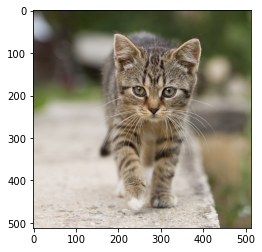

In [2]:
#Read the test image
test_img = Image.open('./cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [39]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [40]:
labels_path = './cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [41]:
from minio import Minio
from kubernetes import client, config
import base64

config.load_incluster_config()
v1 = client.CoreV1Api()
sec = v1.read_namespaced_secret("mlpipeline-minio-artifact", NAMESPACE).data
minio_accesskey = base64.b64decode(sec["accesskey"]).decode('UTF-8')
minio_secretkey = base64.b64decode(sec["secretkey"]).decode('UTF-8')


minio_config = {
            "HOST": "minio-service.kubeflow:9000",
            "ACCESS_KEY": minio_accesskey,
            "SECRET_KEY": minio_secretkey,
            "BUCKET": "mlpipeline",
            "FOLDER": "checkpoint_dir/cifar10"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [42]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [43]:
download_artifact_from_minio(minio_config["FOLDER"],"resnet.pth")
print("[INFO] Downloaded the Model Pth File.....")
download_artifact_from_minio(minio_config["FOLDER"],"cifar10_train.py")
print("[INFO] Downloaded the Model Classifier File.....")

[INFO] Downloaded the Model Pth File.....
[INFO] Downloaded the Model Classifier File.....


In [44]:
from cifar10_train import CIFAR10Classifier
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

CIFAR10Classifier(
  (model_conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

## Captum Vis and Insights

In [45]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: truck ( 0.46911513805389404 )


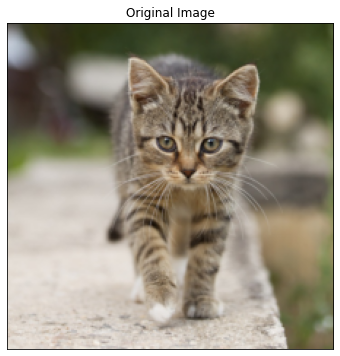

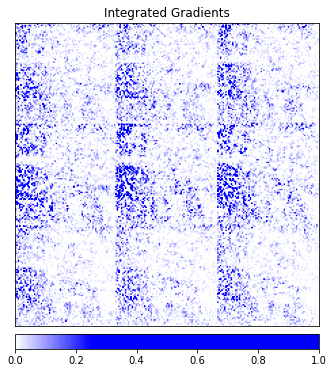

In [46]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [3]:
imgs = ['./cifar10/kitten.png',"./cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

In [48]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [49]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [50]:
visualizer.serve(debug=True,port=6080)


Fetch data and view Captum Insights at http://localhost:6080/



6080

 * Debugger is active!
 * Debugger PIN: 109-049-484
 * Running on http://127.0.0.1:6080/ (Press CTRL+C to quit)


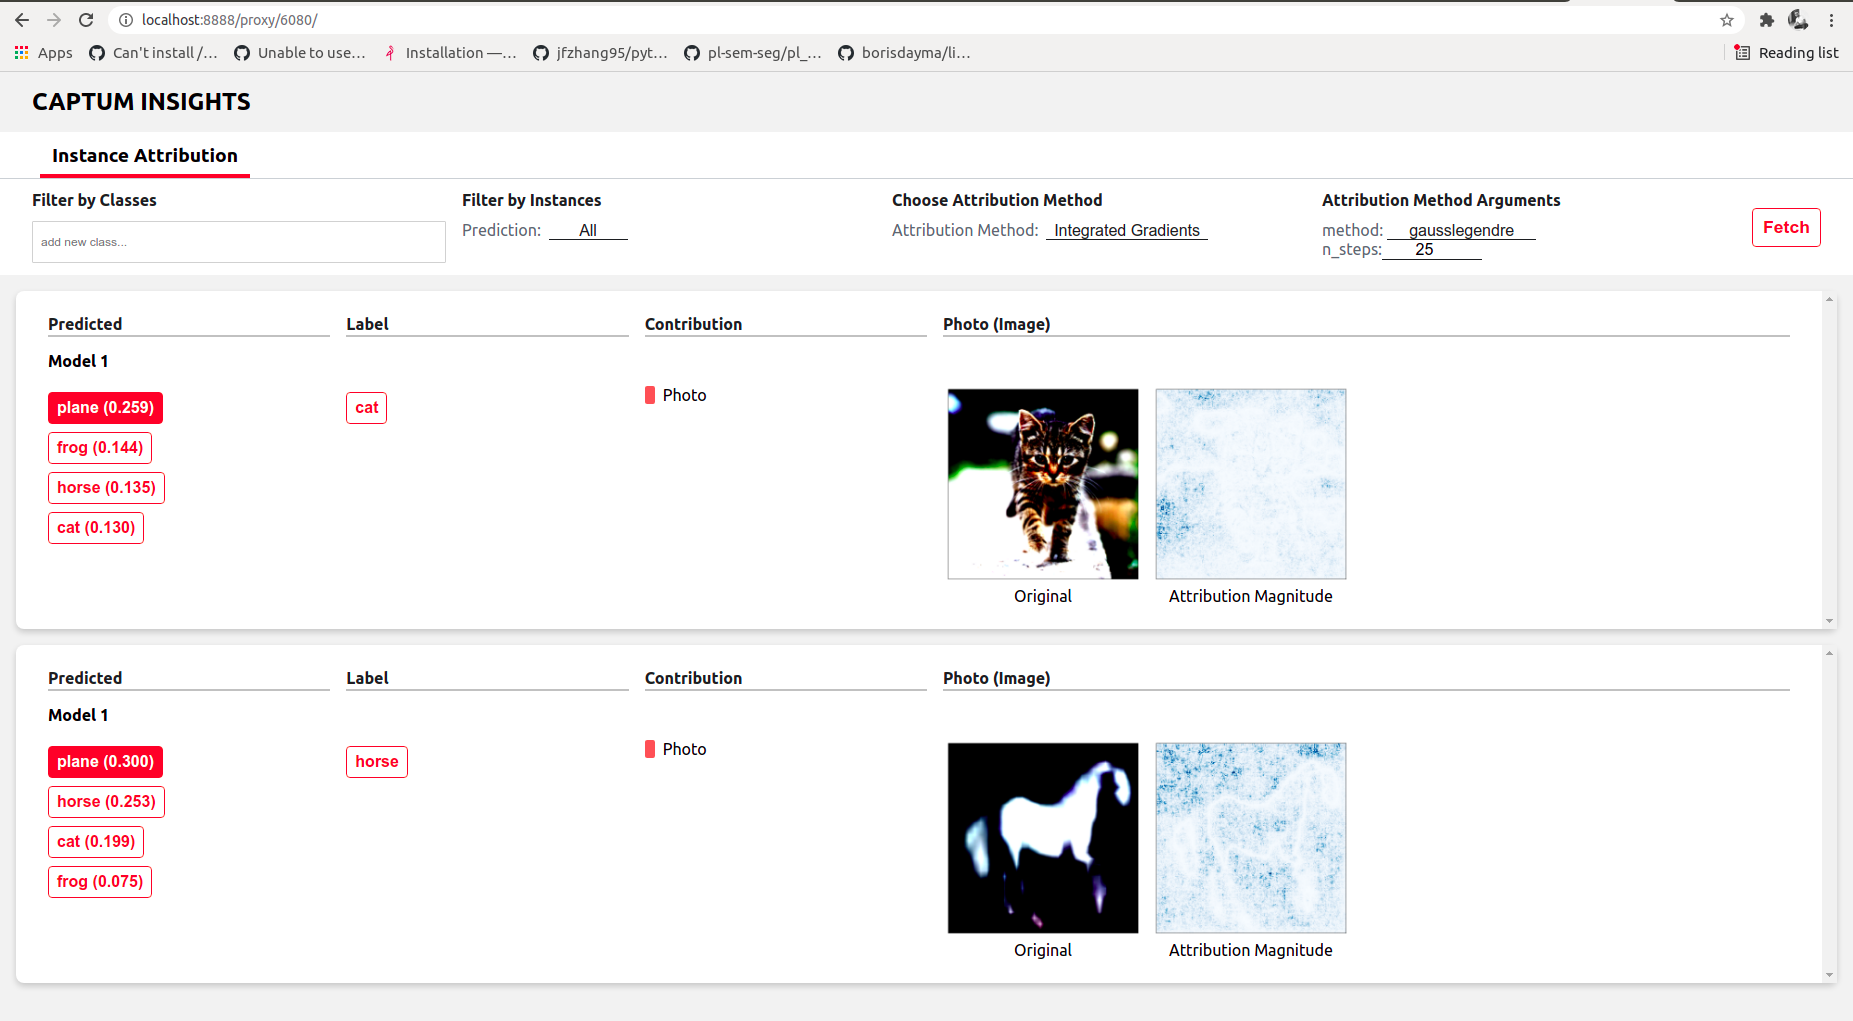

In [83]:
import IPython.display
IPython.display.Image(filename="./cifar10/CIFAR10_Captum_Insights.png")

## Clean up
### Delete Viewers, Inference Services and Completed pods

In [56]:
! kubectl delete --all isvc -n $NAMESPACE

In [ ]:
! kubectl delete pod --field-selector=status.phase==Succeeded -n $NAMESPACE